In [1]:
import os
import glob
import torch
import librosa
import argparse
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from utils.audio import Audio
from utils.hparams import HParam
from model.embedder import SpeechEmbedder
import numpy as np
from glob import glob
import multiprocessing as mp
#import numpy as np
from torch.nn.utils.rnn import pad_sequence

import time

In [2]:
def fileList(ways):
    folders = []
    for i in ways:
        os.chdir(i)
        sp = os.listdir()
        spks = []
        for j in sp:
            way = str(j+"/*/*.wav")
            spks.append(glob(way, recursive=True))
        folders.append(spks)
        os.chdir('..')
    return folders

In [3]:
def fileList(way):
    os.chdir(way)
    sp = os.listdir()
    spks = []
    for j in sp:
        way = str(j+"/*/*.wav")
        spks.append(glob(way, recursive=True))
    #folders.append(spks)
    os.chdir('..')
    return spks

In [5]:
os.chdir("../Data/Saves")

In [18]:
os.chdir("voicefilter-master")

In [16]:
names = fileList(['train-clean-100','train-clean-360'])

In [90]:
names = fileList("wav")

In [87]:
os.chdir("vox1_dev_wav")

FileNotFoundError: [Errno 2] No such file or directory: 'vox1_dev_wav'

In [19]:
hp = HParam('config/conf.yaml')
audio = Audio(hp)
embedder = SpeechEmbedder(hp).cuda()
chkpt_embed = torch.load('embedder.pt')
embedder.load_state_dict(chkpt_embed)
embedder.eval()


/home/anton/Voice Filter/voicefilter-master/utils/hparams.py:18: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  for doc in docs:


SpeechEmbedder(
  (lstm): LSTM(40, 768, num_layers=3, batch_first=True)
  (proj): LinearNorm(
    (linear_layer): Linear(in_features=768, out_features=256, bias=True)
  )
)

In [6]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

In [7]:
device = torch.device('cuda:0')

In [8]:
def getDvec1(way,of = None,du = None ):
    dvec_wav, _ = librosa.load(way, sr=16000 , offset = of , duration = du)
    dvec_mel = audio.get_mel(dvec_wav)
    dvec_mel = torch.from_numpy(dvec_mel).float().cuda()
    dvec = embedder(dvec_mel).cpu()
    dvec = dvec.unsqueeze(0).detach().numpy() 
    return dvec

In [9]:
def getDvec(way,of = None,du = None ):
    dvec_wav, _ = librosa.load(way, sr=16000 , offset = of , duration = du)
    dvec_mel = audio.get_mel(dvec_wav)
    dvec_mel = torch.as_tensor(dvec_mel).to(device)
    dvec = embedder(dvec_mel).unsqueeze(0)
    return dvec

In [10]:
def embedSp(ways):
    embeds = []
    res = []
    for i in ways:
        embeds.append(getDvec(i))
    for i in embeds:
        res.append(i.to('cpu'))
    return pad_sequence(res)

In [108]:
start_time = time.time()
s = []
for i in range(5):
    s.append(embedSp(names[0][0]))
    #torch.cuda.empty_cache()
print("--- %s seconds ---" % (time.time() - start_time))

--- 40.06898331642151 seconds ---


In [179]:
m = torch.as_tensor(np.array([1.0,1]))#.requires_grad_(False)

In [23]:
os.chdir('..')

In [157]:
m = getDvec('train-clean-100/7302/86814/7302-86814-0024-norm.wav')

In [18]:
torch.cuda.empty_cache()

In [150]:
with torch.no_grad():
    os.chdir('train-clean-100')
    t100 = []
    for i in names[0]:
        t100.append(embedSp(i))
        torch.cuda.empty_cache()
    #t100 = pad_sequence(t100)
    os.chdir('..')
    os.chdir('train-clean-360')
    t360 = []
    for i in names[1]:
        t360.append(embedSp(i))
        torch.cuda.empty_cache()
    #t250 = pad_sequence(t250)
    os.chdir('..')

In [35]:
with torch.no_grad():
    os.chdir('wav')
    vox1 = []
    for i in names:
        vox1.append(embedSp(i))
        torch.cuda.empty_cache()
    #t100 = pad_sequence(t100)
    os.chdir('..')

In [36]:
torch.save(vox1,'vox1')

In [15]:
vox1=torch.load('vox1')

In [157]:
torch.save(t100,'t100')
torch.save(t360,'t360')

In [68]:
print(len(vox1[100][0]))

223


In [64]:
import random

In [86]:
for i in range(len(vox1)):
    random.shuffle(vox1[i][0])
for i in range(len(t100)):
    random.shuffle(t100[i][0])
for i in range(len(t100)):
    random.shuffle(t360[i][0])

In [78]:
t360a = t360
random.shuffle(t360)
t360b = t360


In [97]:
random.shuffle(t360)
t360c = t360

In [77]:
len(t360)

921

In [73]:
vox1r = vox1
t100r = t100
t360r = t360

In [78]:
len(t100[0][0])

123

In [14]:
def Cent(wavs):
    sp = []
    for i in wavs:
        per = 0
        m = int(len(i[0]))
        for j in range(m):
            per+=i[0][j]
        sp.append(per/m)
    return sp

In [16]:
Vc = Cent(vox1)

In [21]:
Vct = Cent(t360)

In [232]:
len(Vc[0])

256

In [13]:
def Ptest(wavs,proc):
    sp = []
    for i in wavs:
        per = 0
        m = int(len(i[0])*proc)
        for j in range(m):
            per+=i[0][j]
        sp.append(per/m)
    sp = pad_sequence(sp)
    er = 0
    c=0
    l = len(sp[0])
    for i in range(l):
        for j in (wavs[i][0])[:int(len(wavs[i][0])*(1-proc))]:
            c+=1
            w = pad_sequence([j]*l)
            if(torch.max(cos(sp,w),dim = 0, keepdim=False, out=None)[1] != i):
                er+=1 
    #c = wCount(wavs)
    return [er/c,c]

In [93]:
start_time = time.time()
print(Ptest(t360,0.1))
print("--- %s seconds ---" % (time.time() - start_time))

[0.02943834483819486, 104014]
--- 472.00647354125977 seconds ---


In [118]:
start_time = time.time()
print(Ptest(vox1[:50],0.7))
print("--- %s seconds ---" % (time.time() - start_time))

[0.006936416184971098, 1730]
--- 0.5680005550384521 seconds ---


In [127]:
#изминение в зависимости от кол-ва примеров
r = []
for i in range(9):
    r.append(Ptest(t100,0.06+0.05*i)[0])

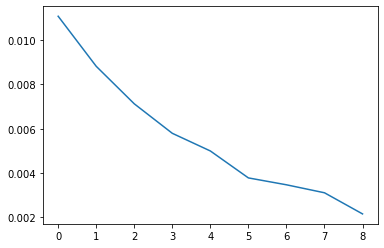

In [134]:
plt.plot(r)

In [141]:
X = []
for i in range(9):
    X.append(5+5*i)

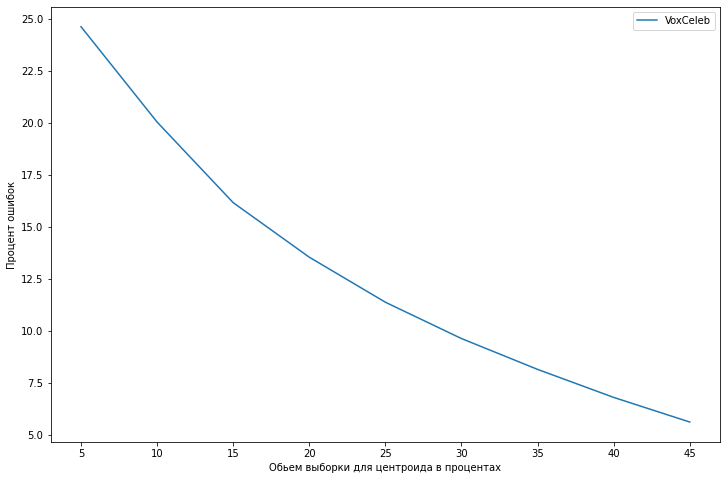

In [212]:

fig, ax = plt.subplots()
plt.plot(X,np.array(rvoxp)*100,label = "VoxCeleb" )
#plt.plot(X[1:],np.array(r360[:8])*100,label = "LibriSpeech" )
#plt.plot(X,np.array(r360)*100,label = "Процент ошибок" )
#plt.plot(X,Y, label = "похожий линейный закон", linestyle = "--")
ax.set_xlabel("Обьем выборки для центроида в процентах")
ax.set_ylabel('Процент ошибок')
ax.legend()
fig.set_figwidth(12)    
fig.set_figheight(8)

In [131]:
#изминение в зависимости от кол-ва примеров
rvoxp = []
for i in range(9):
    rvoxp.append(Ptest(vox1,0.05+0.05*i)[0])

In [138]:
#изминение в зависимости от кол-ва примеров
r360 = []
for i in range(9):
    r360.append(Ptest(t360,0.1+0.05*i)[0])

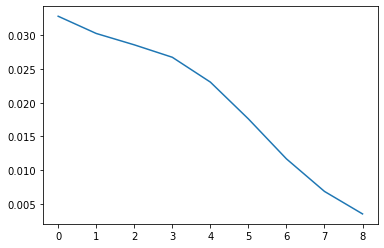

In [139]:
plt.plot(r360)

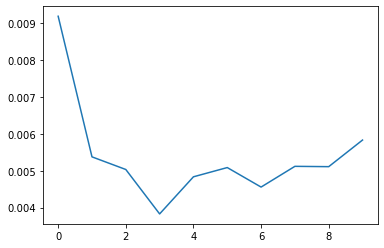

In [161]:
plt.plot(r3602)

In [164]:
#изминение в зависимости от кол-ва спикеров
r3603 = []
for i in range(57):
    r3603.append(Ptest(t360[:20+i*20],0.2)[0])

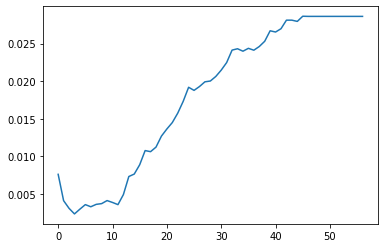

In [167]:
plt.plot(r3603)

In [163]:
#изминение в зависимости от кол-ва спикеров
r3602 = []
for i in range(57):
    r3602.append(Ptest(t360[:20+i*20],0.1)[0])

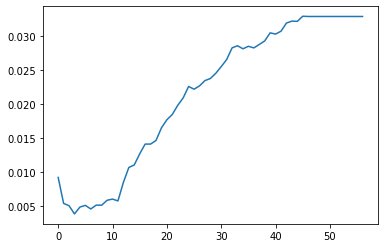

In [168]:
plt.plot(r3602)

In [162]:
#изминение в зависимости от кол-ва спикеров
rvox = []
for i in range(57):
    rvox.append(Ptest(vox1[:20+i*20],0.1)[0])

In [58]:
#изминение в зависимости от кол-ва спикеров
r362 = []
for i in range(45):
    r362.append(Ptest(t360[:20+i*20],0.2)[0])

In [57]:
#изминение в зависимости от кол-ва спикеров
r363 = []
for i in range(45):
    r363.append(Ptest(t360[:20+i*20],0.3)[0])

In [56]:
#изминение в зависимости от кол-ва спикеров
r364 = []
for i in range(45):
    r364.append(Ptest(t360[:20+i*20],0.4)[0])

In [96]:
#изминение в зависимости от кол-ва спикеров
r36 = []
for i in range(45):
    r36.append(Ptest(t360a[:20+i*20],0.3)[0])

In [98]:
#изминение в зависимости от кол-ва спикеров
r36c = []
for i in range(45):
    r36c.append(Ptest(t360c[:20+i*20],0.3)[0])

In [95]:
#изминение в зависимости от кол-ва спикеров
r36b = []
for i in range(45):
    r36b.append(Ptest(t360b[:20+i*20],0.3)[0])

In [52]:
#изминение в зависимости от кол-ва спикеров
r3637 = []
for i in range(45):
    r3637.append(Ptest(t360[:20+i*20],0.375)[0])

In [53]:
#изминение в зависимости от кол-ва спикеров
r361= []
for i in range(45):
    r361.append(Ptest(t360[:20+i*20],0.1)[0])

In [54]:
#изминение в зависимости от кол-ва спикеров
r3635 = []
for i in range(45):
    r3635.append(Ptest(t360[:20+i*20],0.35)[0])

In [55]:
#изминение в зависимости от кол-ва спикеров
r3632 = []
for i in range(45):
    r3632.append(Ptest(t360[:20+i*20],0.325)[0])

In [105]:
r362c = []
for i in range(45):
    r362c.append(Ptest(t360c[:20+i*20],0.2)[0])

In [106]:
r362a = []
for i in range(45):
    r362a.append(Ptest(t360a[:20+i*20],0.2)[0])

In [107]:
r362b = []
for i in range(45):
    r362b.append(Ptest(t360b[:20+i*20],0.2)[0])

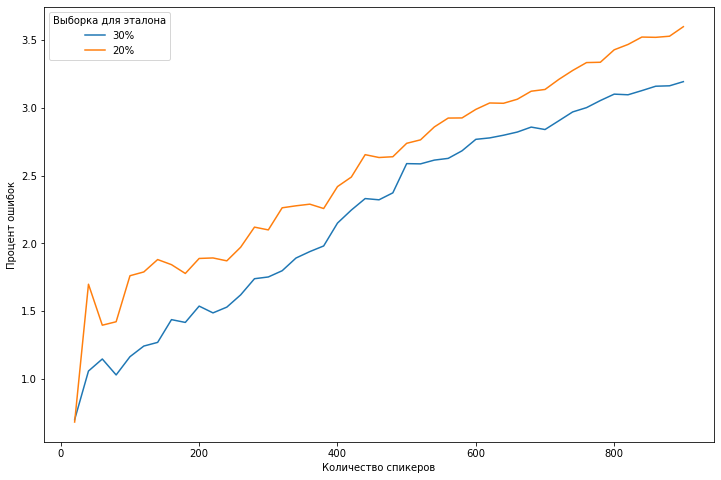

In [108]:
fig, ax = plt.subplots()
#plt.plot(N30,np.array(r361[:30])*100,label = "10%" )
#plt.plot(N45,np.array(r36c)*100,label = "20%" )
#plt.plot(N45,np.array(r36b)*100,label = "20%" )
plt.plot(N45,(np.array(r36b)*100+np.array(r36)*100+np.array(r361)*100+np.array(r36c)*100)/4,label = "30%" )
plt.plot(N45,(np.array(r362b)*100+np.array(r362a)*100+np.array(r362)*100+np.array(r362c)*100)/4,label = "20%" )
#plt.plot(X,np.array(r360)*100,label = "Процент ошибок" )
#plt.plot(X,Y, label = "похожий линейный закон", linestyle = "--")
ax.set_xlabel("Количество спикеров")
ax.set_ylabel('Процент ошибок')
ax.legend(title = 'Выборка для эталона')
#ax.legend("Процент примеров для эталона")
fig.set_figwidth(12)    
fig.set_figheight(8)

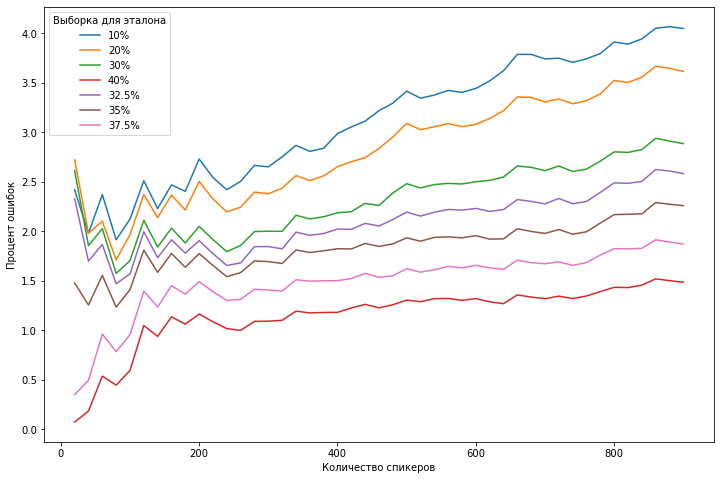

In [62]:
fig, ax = plt.subplots()
plt.plot(N45,np.array(r361)*100,label = "10%" )
plt.plot(N45,np.array(r362)*100,label = "20%" )
plt.plot(N45,np.array(r363)*100,label = "30%" )
plt.plot(N45,np.array(r364)*100,label = "40%" )
plt.plot(N45,np.array(r3632)*100,label = "32.5%" )
plt.plot(N45,np.array(r3635)*100,label = "35%" )
plt.plot(N45,np.array(r3637)*100,label = "37.5%" )

#plt.plot(X,np.array(r360)*100,label = "Процент ошибок" )
#plt.plot(X,Y, label = "похожий линейный закон", linestyle = "--")
ax.set_xlabel("Количество спикеров")
ax.set_ylabel('Процент ошибок')
ax.legend(title = 'Выборка для эталона')
#ax.legend("Процент примеров для эталона")
fig.set_figwidth(12)    
fig.set_figheight(8)

In [132]:
#изминение в зависимости от кол-ва спикеров
rvox2 = []
for i in range(57):
    rvox2.append(Ptest(vox1[:20+i*20],0.2)[0])

In [185]:
#изминение в зависимости от кол-ва спикеров
rvox3 = []
for i in range(57):
    rvox3.append(Ptest(vox1[:20+i*20],0.3)[0])

In [184]:
#изминение в зависимости от кол-ва спикеров
rvox05 = []
for i in range(57):
    rvox05.append(Ptest(vox1[:20+i*20],0.05)[0])

In [179]:
N = []
for i in range(57):
    N.append(20+20*i)

In [83]:
N45 = []
for i in range(45):
    N45.append(20+20*i)

In [84]:
N30 = []
for i in range(30):
    N30.append(20+20*i)

In [47]:
len(vox1)

1211

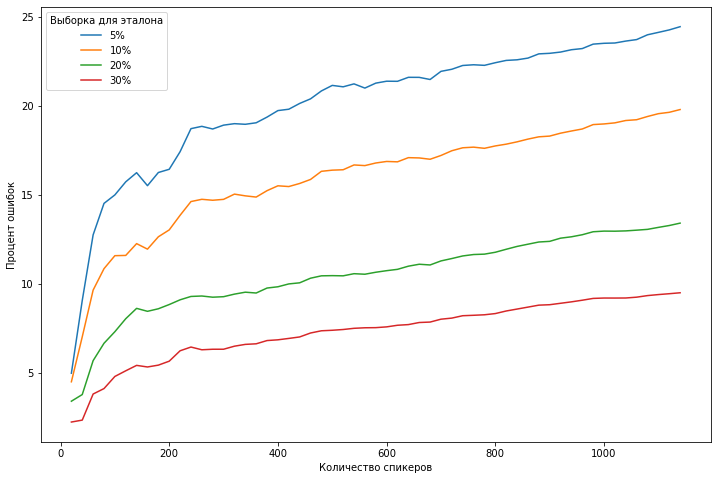

In [220]:
#plt.plot(rvox2)  

fig, ax = plt.subplots()
plt.plot(N,np.array(rvox05)*100,label = "5%" )
plt.plot(N,np.array(rvox)*100,label = "10%" )
plt.plot(N,np.array(rvox2)*100,label = "20%" )
plt.plot(N,np.array(rvox3)*100,label = "30%" )


#plt.plot(X,np.array(r360)*100,label = "Процент ошибок" )
#plt.plot(X,Y, label = "похожий линейный закон", linestyle = "--")
ax.set_xlabel("Количество спикеров")
ax.set_ylabel('Процент ошибок')
ax.legend(title = 'Выборка для эталона')
#ax.legend("Процент примеров для эталона")
fig.set_figwidth(12)    
fig.set_figheight(8)

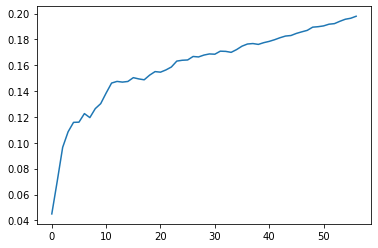

In [166]:
plt.plot(rvox)

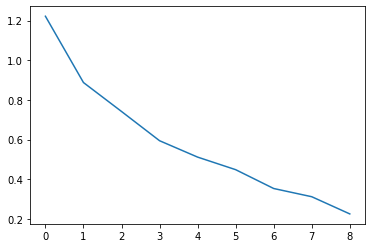

In [124]:
plt.plot(np.array(r)*100)

In [ ]:
erS = []
for i in range(15):
    erC.append(test(vox1[:30+i*20],pdV1c[:,:30+i*20]))

In [13]:
def test(wavs,spks):
    er = 0
    l = len(spks[0])
    for i in range(l):
        for j in wavs[i][0]:
            w = pad_sequence([j]*l)
            if(torch.max(cos(spks,w),dim = 0, keepdim=False, out=None)[1] != i):
                er+=1 
    c = wCount(wavs)
    return [er/c,c]

In [74]:
sp100 = []
for i in t100:
    sp100.append((i[0][0]+i[0][-1])/2)
sp360 = []
for i in t360:
    sp360.append((i[0][0]+i[0][-1])/2)    

In [75]:
spV1 = []
for i in vox1:
    spV1.append((i[0][0]+i[0][-1])/2)


In [87]:
spV1a = []
for i in vox1:
    v = 0
    for j in i[0]:
        v+=j
    spV1a.append(v/len(i[0]))


In [24]:
pd100 = pad_sequence(sp100)#.reshape(251,256)
pd360 = pad_sequence(sp360)#.reshape(921,256)

In [39]:
pdV1 = pad_sequence(spV1)#.reshape(921,256)

In [56]:
pdV1b = pad_sequence(spV1b)#.reshape(921,256)

In [81]:
pdV1a = pad_sequence(spV1a)#.reshape(921,256)

In [86]:
pdV1c = pad_sequence(spV1c)#.reshape(921,256)

In [40]:
len(pdV1[0])

1211

In [344]:
len(t10[0][0])

123

In [45]:
len(pdV1[0])

1211

In [41]:
len(pdV1[0])

1211

In [12]:
def wCount(wavs):
    c = 0
    for i in wavs:
        c+=len(i[0])
    return c

In [53]:
wCount(vox1)

148642

In [14]:
def stat(wavs,spks):
    t = []
    f = []
    l = len(spks[0])
    for i in range(l):
        t1 = 0
        f1 = 0
        for j in wavs[i][0]:
            w = pad_sequence([j]*l)
            c = cos(spks,w)
            t1 += c[i]
            f1 +=c
        t.append(t1/len(wavs[i][0]))
        f.append(f1/len(wavs[i][0]))
    return [t,f]

In [54]:
start_time = time.time()
print(test(vox1,pdV1))
print("--- %s seconds ---" % (time.time() - start_time))

[0.4022012620928136, 148642]
--- 944.1837742328644 seconds ---


In [57]:
start_time = time.time()
print(test(vox1,pdV1b))
print("--- %s seconds ---" % (time.time() - start_time))

[0.23262604109201976, 148642]
--- 949.8923962116241 seconds ---


In [88]:
start_time = time.time()
print(test(vox1,pdV1c))
print("--- %s seconds ---" % (time.time() - start_time))

[0.25572852894874937, 148642]
--- 949.9596271514893 seconds ---


In [82]:
start_time = time.time()
print(test(vox1,pdV1a))
print("--- %s seconds ---" % (time.time() - start_time))

[0.09576701066993178, 148642]
--- 952.7180089950562 seconds ---


In [385]:
start_time = time.time()
print(test(t360,pd360))
print("--- %s seconds ---" % (time.time() - start_time))

[0.024592843271098123, 104014]
--- 543.6435379981995 seconds ---


In [501]:
start_time = time.time()
print(test(t100,pd100))
print("--- %s seconds ---" % (time.time() - start_time))

[0.018325799782753425, 28539]
--- 43.5232150554657 seconds ---


In [59]:
er = []
for i in range(59):
    er.append(test(vox1[:20+i*20],pdV1b[:,:20+i*20]))

In [89]:
erA = []
for i in range(59):
    erA.append(test(vox1[:20+i*20],pdV1a[:,:20+i*20]))

In [150]:
torch.save(er,'er')

In [91]:
len(erC)

57

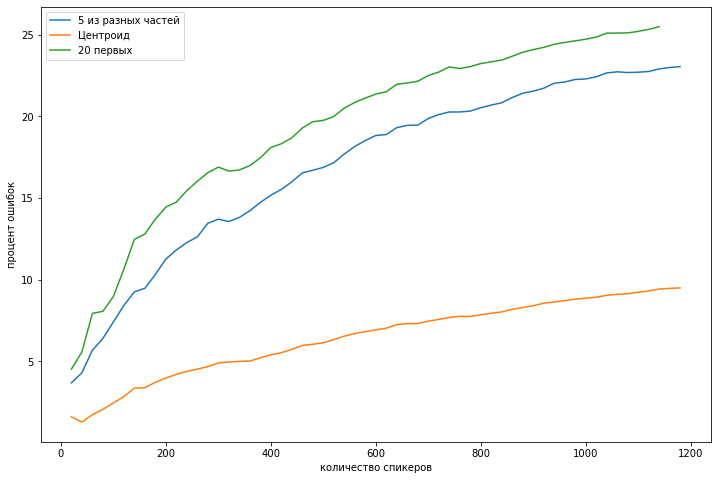

In [147]:

fig, ax = plt.subplots()
plt.plot(X,e,label = '5 из разных частей')
plt.plot(X,eA,label = 'Центроид')
plt.plot(Xc,eC,label = '20 первых')
#plt.plot(X,Y, label = "похожий линейный закон", linestyle = "--")
ax.set_xlabel("количество спикеров")
ax.set_ylabel('процент ошибок')
ax.legend()
fig.set_figwidth(12)    
fig.set_figheight(8)

In [551]:
p = (pd360.reshape(921,256))[:2].reshape(256,2)

In [557]:
w = pad_sequence([t360[0][0][0]]*2)

In [558]:
cos(p,w)

tensor([ 0.0090, -0.0338])

In [568]:
len(pd360[:,:50][0])

50

In [111]:
len(er)

59

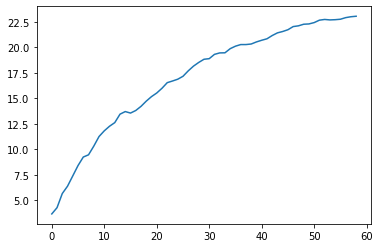

In [124]:
plt.plot(e)

In [123]:
e = np.array(e)*100

In [118]:
len(e[0])

2

In [104]:
X = []
for i in range(59):
    X.append(20+i*20)

In [106]:
Xc = []
for i in range(57):
    Xc.append(20+i*20)

In [120]:
e = []
for i in er:
    e.append(i[0])

In [125]:
eA = []
for i in erA:
    eA.append(i[0])
eA = np.array(eA)*100

In [126]:
eC = []
for i in erC:
    eC.append(i[0])
eC = np.array(eC)*100

In [62]:
Y = []
for i in range(59):
    Y.append(1.2+(20+i*20)*0.00135)

In [618]:
torch.save(e1,'ErFromN')

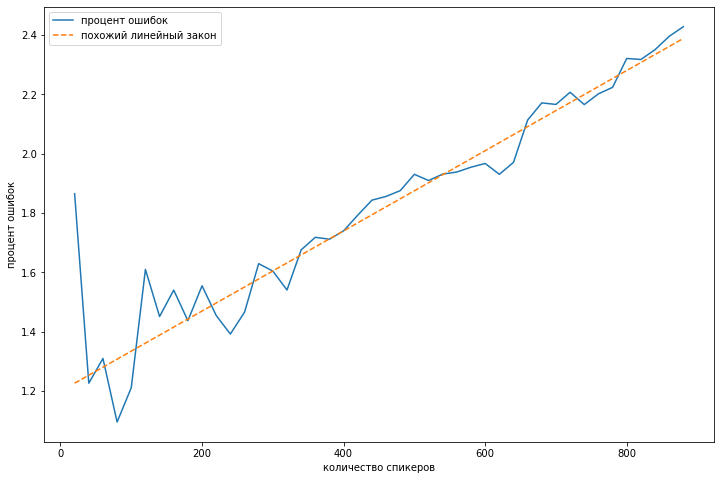

In [616]:
fig, ax = plt.subplots()
plt.plot(X,e1,label = 'процент ошибок')
plt.plot(X,Y, label = "похожий линейный закон", linestyle = "--")
ax.set_xlabel("количество спикеров")
ax.set_ylabel('процент ошибок')
ax.legend()
fig.set_figwidth(12)    
fig.set_figheight(8)  

In [532]:
len((pd360.reshape(921,256))[:50].reshape(256,50)[0])

50

In [549]:
e

[0.9495251494899754,
 0.9914197257850509,
 0.9976561584436892,
 0.9927523499956075,
 0.9985191453353078,
 0.9970371674147086,
 0.9987990392313851,
 0.9969717583550942,
 0.9990612899440685,
 0.9961003670242801,
 0.9964429422179302,
 0.9978915396184129,
 0.9976070700203943,
 0.9986400896533488,
 0.9988580846430043,
 0.9988507652356484,
 0.9964419105483827,
 0.9985170198974681]

In [442]:
start_time = time.time()
stats = stat(t360,pd360)
print("--- %s seconds ---" % (time.time() - start_time))

--- 558.9101288318634 seconds ---


In [132]:
start_time = time.time()
stats = stat(vox1,pdV1a)
print("--- %s seconds ---" % (time.time() - start_time))

--- 989.6302897930145 seconds ---


In [138]:
start_time = time.time()
statsC = stat(vox1,pdV1c)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1063.0469768047333 seconds ---


In [464]:
len(stats)

2

In [167]:
def normF(stats):
    d = []
    S = []
    l = len(stats)
    for i in range(l):
        s1 = 0
        s2 = 0
        for j in range(len(stats[i])):
            if(i!=j):
                s1+=stats[i][j]
                s2+=stats[i][j]*stats[i][j]
        
        s1 = (s1/l)
        S.append(s1)
        d.append(torch.sqrt((s2/l-s1**2)))
    return [S,d]
            

In [166]:
def normT(stats):
    d = []
    S = []
    l = len(stats)
    for i in range(l):
        s1 = 0
        s2 = 0
        for j in range(len(stats[i])):
            if(i!=j):
                s1+=stats[i][j]
                s2+=stats[i][j]*stats[i][j]
        
        s1 = (s1/l)
        S.append(s1)
        d.append(torch.sqrt((s2/l-s1**2)))
    return [S,d]

In [133]:
D = normF(stats[1])

In [139]:
Dc = normF(statsC[1])

In [617]:
torch.save([s1,d1],'stats')

In [134]:
N = []
for i in range(len(stats[0])):
    N.append(i)

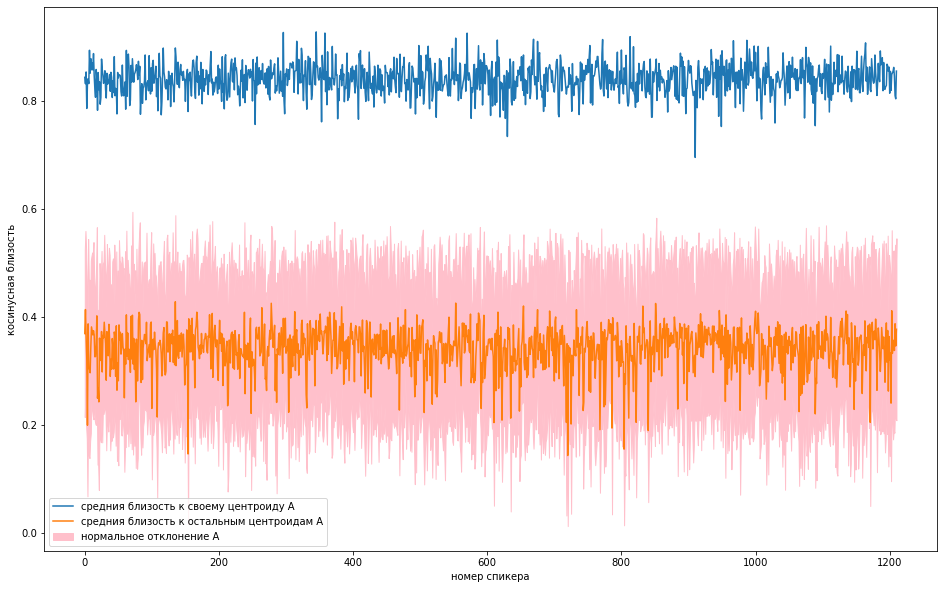

In [144]:
fig, ax = plt.subplots()
plt.plot(stats[0],label = 'средния близость к своему центроиду А')
plt.plot(s1,label = 'средния близость к остальным центроидам А')
ax.fill_between(N,s1-d1, s1+d1,color = 'pink', label = 'нормальное отклонение А')

ax.set_xlabel("номер спикера")
ax.set_ylabel('косинусная близость')
ax.legend()
fig.set_figwidth(16)    
fig.set_figheight(10)  

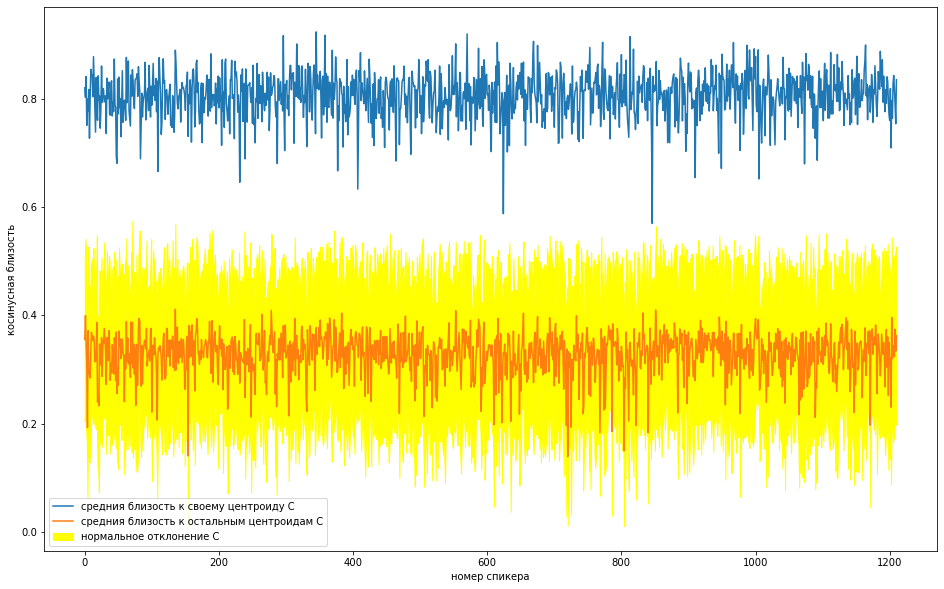

In [145]:
fig, ax = plt.subplots()
plt.plot(statsC[0],label = 'средния близость к своему центроиду С')
plt.plot(sC1,label = 'средния близость к остальным центроидам С')
ax.fill_between(N,sC1-dC1, sC1+dC1,color = 'yellow', label = 'нормальное отклонение С')
ax.set_xlabel("номер спикера")
ax.set_ylabel('косинусная близость')
ax.legend()
fig.set_figwidth(16)    
fig.set_figheight(10)  

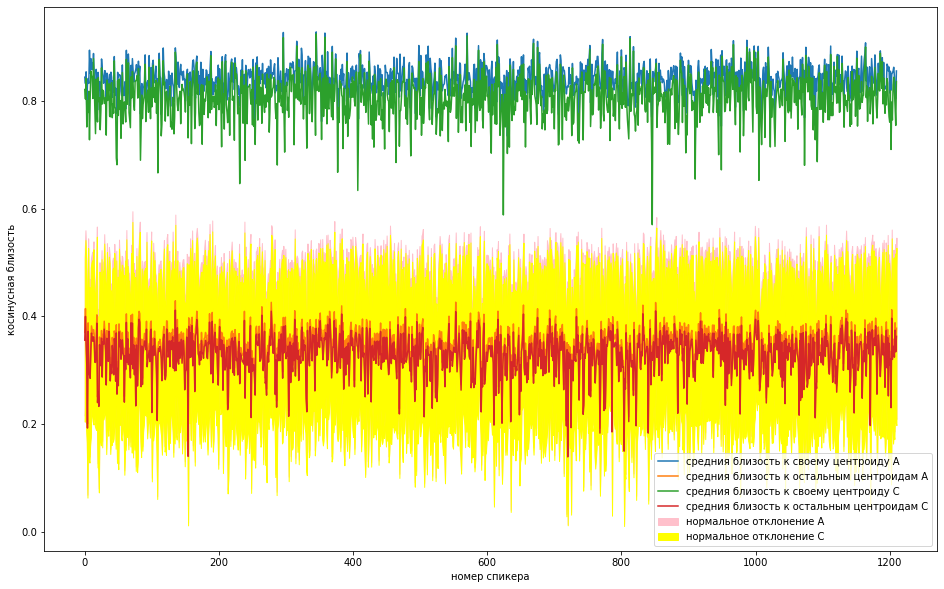

In [143]:
fig, ax = plt.subplots()
plt.plot(stats[0],label = 'средния близость к своему центроиду А')
plt.plot(s1,label = 'средния близость к остальным центроидам А')
ax.fill_between(N,s1-d1, s1+d1,color = 'pink', label = 'нормальное отклонение А')
plt.plot(statsC[0],label = 'средния близость к своему центроиду С')
plt.plot(sC1,label = 'средния близость к остальным центроидам С')
ax.fill_between(N,sC1-dC1, sC1+dC1,color = 'yellow', label = 'нормальное отклонение С')
ax.set_xlabel("номер спикера")
ax.set_ylabel('косинусная близость')
ax.legend()
fig.set_figwidth(16)    
fig.set_figheight(10)  

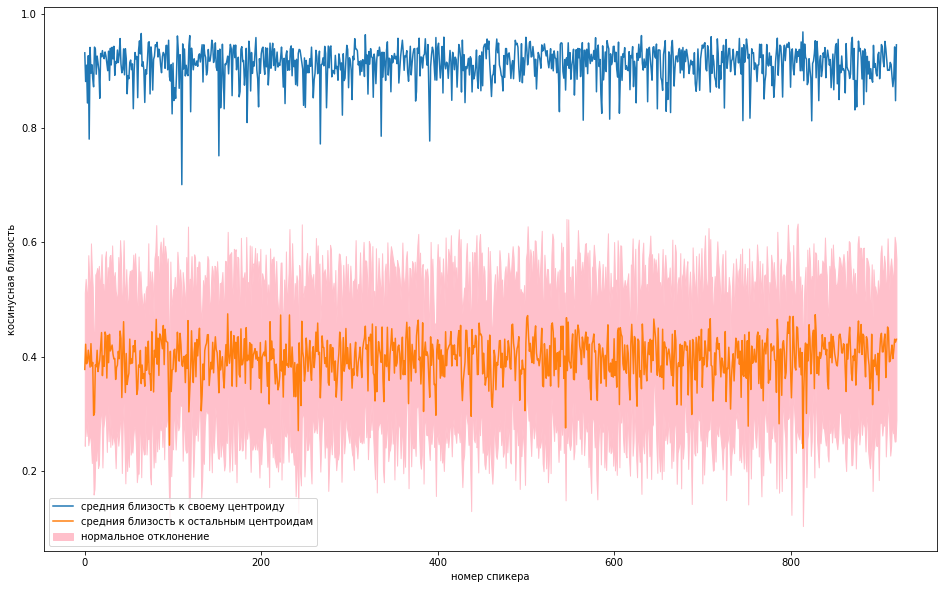

In [500]:
fig, ax = plt.subplots()
plt.plot(stats[0],label = 'средния близость к своему центроиду')
plt.plot(s1,label = 'средния близость к остальным центроидам')
ax.fill_between(N,s1-d1, s1+d1,color = 'pink', label = 'нормальное отклонение')
ax.set_xlabel("номер спикера")
ax.set_ylabel('косинусная близость')
ax.legend()
fig.set_figwidth(16)    
fig.set_figheight(10)  

In [140]:
sC1 = torch.tensor(Dc[0])
dC1 = torch.tensor(Dc[1])

In [136]:
s1 = torch.tensor(D[0])
d1 = torch.tensor(D[1])

In [391]:
len(pd360[0])

921

In [420]:
w = pad_sequence([t360[500][0][0]]*921)
st = cos(pd360,w)

In [439]:
st[]

SyntaxError: invalid syntax (<ipython-input-439-b27cefd2fb98>, line 1)

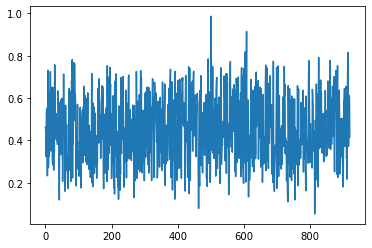

In [421]:
plt.plot(st)
#plt.plot(st[5:])

In [386]:
start_time = time.time()
print(test(t100,pd100))
print("--- %s seconds ---" % (time.time() - start_time))

[0.018325799782753425, 28539]
--- 41.37557649612427 seconds ---


In [379]:
wCount(t100)

28539

In [311]:
cos(sp100[0],t100[0][0][121])

tensor(0.9283)

In [361]:
if(torch.max(cos(pd100,k),dim = 0, keepdim=False, out=None)[1] == 1):
    print('x')

x


In [258]:
cos(b,b)

tensor(1.)

In [246]:
len(t100[0][0][2])

256

In [358]:
b = t100[1][0][121]

In [359]:
k = pad_sequence([b]*251)#.reshape(251,256)

In [191]:
print(len(t100[3][0][0]))

256


In [190]:
print(len(pd100))

251


In [156]:
os.listdir()

['Emdedder2', 'Other50_8_20', 'spks,S,M,M2', 'Embeds250', '250_8']

In [155]:
os.chdir('Saves')

In [149]:
torch.max(cos(a,b))

tensor(0.1337)

In [97]:
a = t100[0][0]

In [65]:
print(len(t250[0][0]))

126


In [139]:
b = t250[0][0][0]

In [140]:
b = [b]*123

In [141]:
b = pad_sequence(b)

In [142]:
len(b.reshape(123,256))

123

In [144]:
b = b.reshape(123,256)

In [113]:
b = b.unsqueeze(0)

In [96]:
print(len(t100[0][0]))

123


In [86]:
print(len(t100[0][0]))

123


In [18]:
a = torch.randn(1,256)
b = torch.randn(1,256)

In [10]:
os.chdir('LibriSpeech')

In [200]:
len(a[0])

256

In [209]:
c = cos(a,b)

In [210]:
c[0]

tensor(0.0057)

In [22]:
start_time = time.time()
p1 = []
p2 = []
for i in range(100000):
    p1.append(a)
    p2.append(b)
p1 = pad_sequence(p1)
p2 = pad_sequence(p2)
cos(p1,p2)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.2345998287200928 seconds ---


In [19]:
start_time = time.time()
res = []
for i in range(100000):
    res.append(cos(a,b))
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.353100061416626 seconds ---


In [10]:
from torch.nn.utils.rnn import pad_sequence
p = pad_sequence([a,b]) #torch.Size([25, 3, 300])

In [63]:
torch.cuda.empty_cache()

In [12]:
os.chdir("Saves")

In [11]:
t360 = torch.load('t360')

In [12]:
t100 = torch.load('t100')

In [29]:
len(sp360[0])

256

In [50]:
f = []
for i in sp360:
    f.append(cos(i,sp100[20]))

In [51]:
print(np.max(f))

0.8369997


In [295]:
len(part[0])

256

In [296]:
cos(Vc[0],part[0])

tensor(0.9013, grad_fn=<DivBackward0>)

In [292]:
#v = librosa.load(names[0][0],sr = 16000,offset = None, duration = None)
part = getDvec(names[0][0],du = 0.9+i*0.4).to('cpu')

In [297]:
def lenTest(wav,spk):
    co = []
    t = []
    full = spk
    v = librosa.load(wav,sr = 16000,offset = None, duration = None)
    #print(lens(v))
    l = int((lens(v) - 0.8)/0.4)
    for i in range(l):
        part = getDvec(wav,du = 0.8+i*0.4).to('cpu')
        co.append(cos(full,part[0]))
        t.append(0.8+i*0.4)
    return co

In [159]:
def lenTest2(wav,spk):
    co = []
    t = []
    full = spk
    ot = []
    v = librosa.load(wav,sr = 16000,offset = None, duration = None)
    #print(lens(v))
    l = int((lens(v) - 0.8)/0.4)
    for i in range(l):
        part = getDvec(wav,du = 0.8+i*0.4).to('cpu')
        co.append(cos(full,part[0]))
        oth = []
        for j in range(20):
            oth.append(cos(Vc[j],part[0]))
        t.append(0.8+i*0.4)
        ot.append(max(oth))
    return [co,ot]

In [99]:
def lens(wav):
    return len(wav[0])/16000

In [237]:
l = os.listdir()

In [235]:
os.chdir("wav")

In [266]:
len(Vc[0])

256

In [160]:
with torch.no_grad():
    his1 = []
    for i in range(20):
        a = []
        for j in range(10):
            a.append(lenTest2(names[i+20][j],Vc[i+20]))
        his1.append(a)

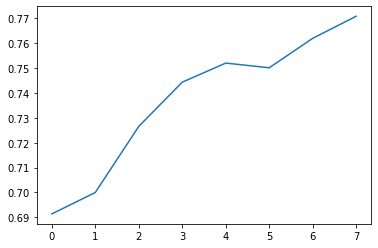

In [18]:
plt.plot(his[450][10][0])

In [116]:
def Smean(data):
    m = []
    times = []
    for i in range(14):
        fm = []
        times.append(0.8+i*0.4)
        for j in range(10):
            for k in range(20):
                if(len(data[j][k][0])>i):
                    fm.append(data[j][k][0][i])
        m.append(np.mean(fm))
    return [times,m]

In [125]:
def SmeanOth(data):
    m = []
    times = []
    for i in range(14):
        fm = []
        times.append(0.8+i*0.4)
        for j in range(10):
            for k in range(10):
                if(len(data[j][k][1])>i):
                    fm.append(data[j][k][1][i])
        m.append(np.mean(fm))
    return [times,m]

In [117]:
def disp(data,M):
    D = []
    for i in range(14):
        S = []
        for j in range(10):
            for k in range(20):
                if(len(data[j][k][0])>i):
                    S.append((data[j][k][0][i] - M[i])**2)
        #D.append(np.mean(S)**(1/2))
        D.append(np.mean(S))
    return D

In [126]:
def dispOth(data,M):
    D = []
    for i in range(14):
        S = []
        for j in range(10):
            for k in range(10):
                if(len(data[j][k][1])>i):
                    S.append((data[j][k][1][i] - M[i])**2)
        #D.append(np.mean(S)**(1/2))
        D.append(np.mean(S))
    return D

In [119]:
d = np.sqrt(disp(his,s[1]))

In [162]:
d1 = np.sqrt(dispOth(his1,So[1]))

In [161]:
So = np.array(SmeanOth(his1))

In [118]:
s = Smean(his)

In [163]:
ls = np.array(s[1])-d
lh = np.array(s[1])+d
lso = np.array(So[1])-d1
lho = np.array(So[1])+d1

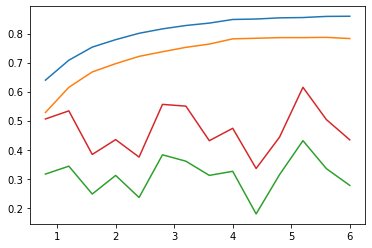

In [60]:
#plt.plot(s[0],np.array(s[1])+d)
plt.plot(s[0],np.array(s[1]))
plt.plot(s[0],np.array(s[1])-d)
plt.plot(s[0],np.array(So[1]))
plt.plot(s[0],np.array(So[1])+d1)

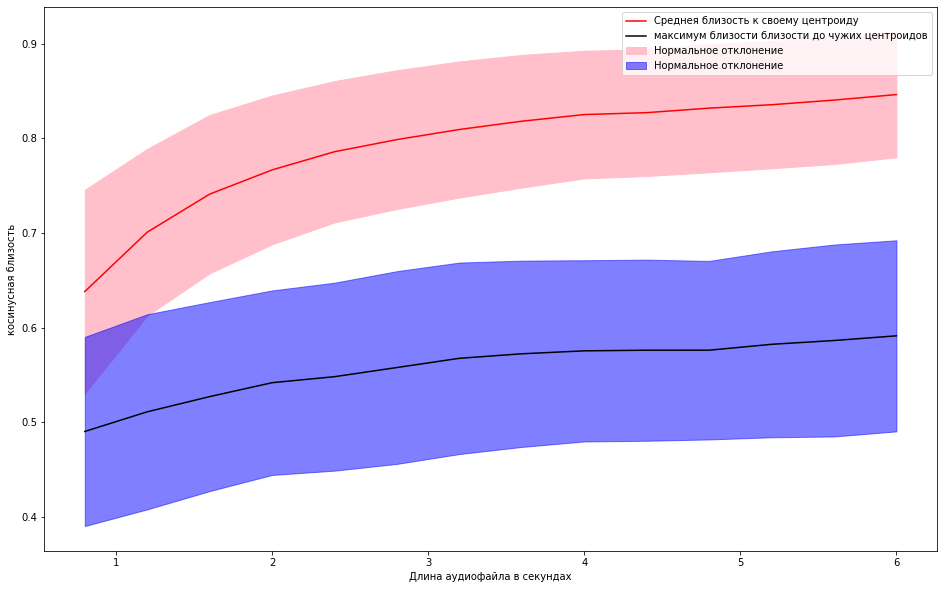

In [165]:

fig, ax = plt.subplots()
plt.plot(s[0],s[1],color = 'red',label = 'Среднея близость к своему центроиду')
plt.plot(s[0],So[1],color = 'black',label = 'максимум близости близости до чужих центроидов')
#plt.plot(s[0],Mm,color = 'green',label = 'максимум близости к чужому центроиду (из 20)')
ax.fill_between(s[0], ls, lh,color = 'pink', label = 'Нормальное отклонение')
ax.fill_between(s[0], lso, lho,alpha = 0.5,color = 'blue', label = 'Нормальное отклонение')
ax.set_xlabel("Длина аудиофайла в секундах")
ax.set_ylabel('косинусная близость')
ax.legend()
fig.set_figwidth(16)    
fig.set_figheight(10)  

In [97]:
os.chdir("wav")

In [17]:
his = torch.load("his")

In [29]:
Err = []
Ero = []
#for i in range(len(vox1))
l=100
Vcp = pad_sequence(Vc[:l])
for i in range(l):
    er = []
    eo = []
    for j in vox1[i][0]:
        w = pad_sequence([j]*l)
        c = cos(w,Vcp)
        er.append(c[i])
        eop = []
        for k in range(len(c)):
            if(k!=i):
                eop.append(c[k])
        eo.append(eop)
    Err.append(er)
    Ero.append(eo)
    

In [237]:
Ero[1][2]

[tensor(0.4695), tensor(0.4027)]

In [20]:
def MD(Ero):
    M = []
    D = []
    l = len(Ero)
    for i in range(l):
        s = 0
        d = 0
        li = len(Ero[i])
        for j in range(li):
            s+=Ero[i][j]
        s = s/li
        M.append(s)
        for j in range(li):
            d+=(Ero[i][j])**2
        d = d/li-s**2
        D.append(np.sqrt(d))
    return [M,D]
            

In [30]:
mdr = MD(Err)

In [31]:
mdm = []
mdd = []
for i in range(100):
    res = MD(Ero[i])
    mdm.append(np.mean(res[0]))
    mdd.append(np.mean(res[1]))

In [37]:
Err1 = []
Ero1 = []
#for i in range(len(vox1))
l=100
Vcp = pad_sequence(Vct[:l])
for i in range(l):
    er = []
    eo = []
    for j in t360[i][0]:
        w = pad_sequence([j]*l)
        c = cos(w,Vcp)
        er.append(c[i])
        eop = []
        for k in range(len(c)):
            if(k!=i):
                eop.append(c[k])
        eo.append(eop)
    Err1.append(er)
    Ero1.append(eo)
mdr1 = MD(Err1)
mdm1 = []
mdd1 = []
for i in range(100):
    res = MD(Ero1[i])
    mdm1.append(np.mean(res[0]))
    mdd1.append(np.mean(res[1]))

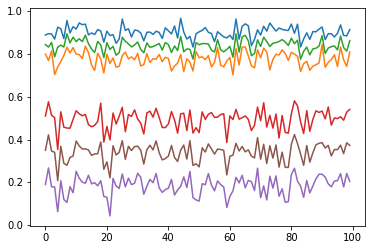

In [269]:
plt.plot(np.array(mdr[0])+mdr[1])
plt.plot(np.array(mdr[0])-mdr[1])
plt.plot(np.array(mdr[0]))
plt.plot(np.array(mdm)+mdd)
plt.plot(np.array(mdm)-mdd)
plt.plot(mdm)

In [27]:
N = []
for i in range(100):
    N.append(i)

In [25]:
#Vox

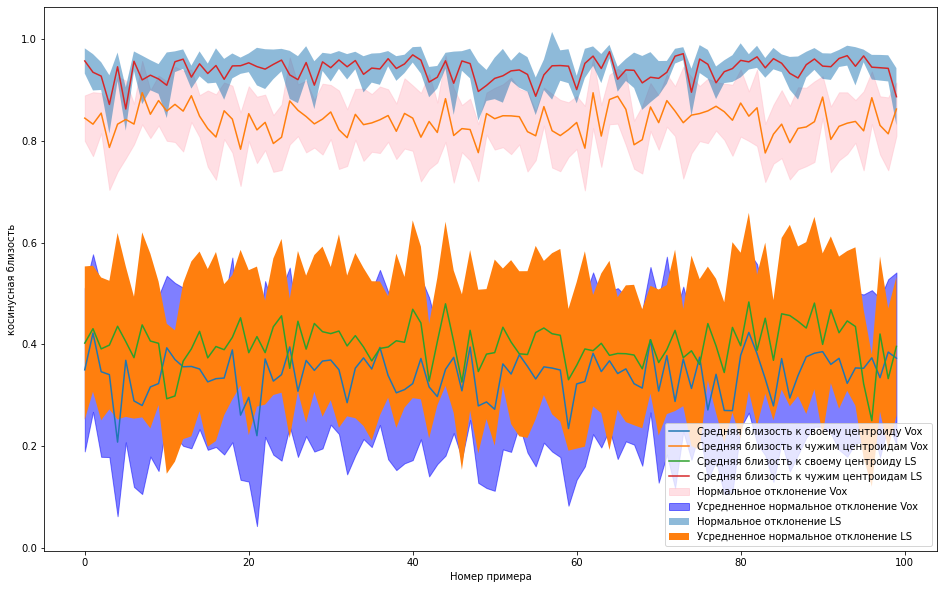

In [46]:

fig, ax = plt.subplots()
plt.plot(mdm,label = "Средняя близость к своему центроиду Vox")
plt.plot(np.array(mdr[0]),label = "Средняя близость к чужим центроидам Vox")
#plt.plot(s[0],Mm,color = 'green',label = 'максимум близости к чужому центроиду (из 20)')
ax.fill_between(N,np.array(mdr[0])-mdr[1],np.array(mdr[0])+mdr[1],alpha = 0.5,color = 'pink', label = 'Нормальное отклонение Vox')
ax.fill_between(N,np.array(mdm)-mdd,np.array(mdm)+mdd,color = 'blue',alpha = 0.5, label = 'Усредненное нормальное отклонение Vox')
plt.plot(mdm1,label = "Средняя близость к своему центроиду LS")
plt.plot(np.array(mdr1[0]),label = "Средняя близость к чужим центроидам LS")
#plt.plot(s[0],Mm,color = 'green',label = 'максимум близости к чужому центроиду (из 20)')
ax.fill_between(N,np.array(mdr1[0])-mdr1[1],np.array(mdr1[0])+mdr1[1],alpha = 0.5, label = 'Нормальное отклонение LS')
ax.fill_between(N,np.array(mdm1)-mdd1,np.array(mdm1)+mdd1, label = 'Усредненное нормальное отклонение LS')
ax.set_xlabel("Номер примера")
ax.set_ylabel('косинусная близость')
ax.legend()
fig.set_figwidth(16)    
fig.set_figheight(10)  

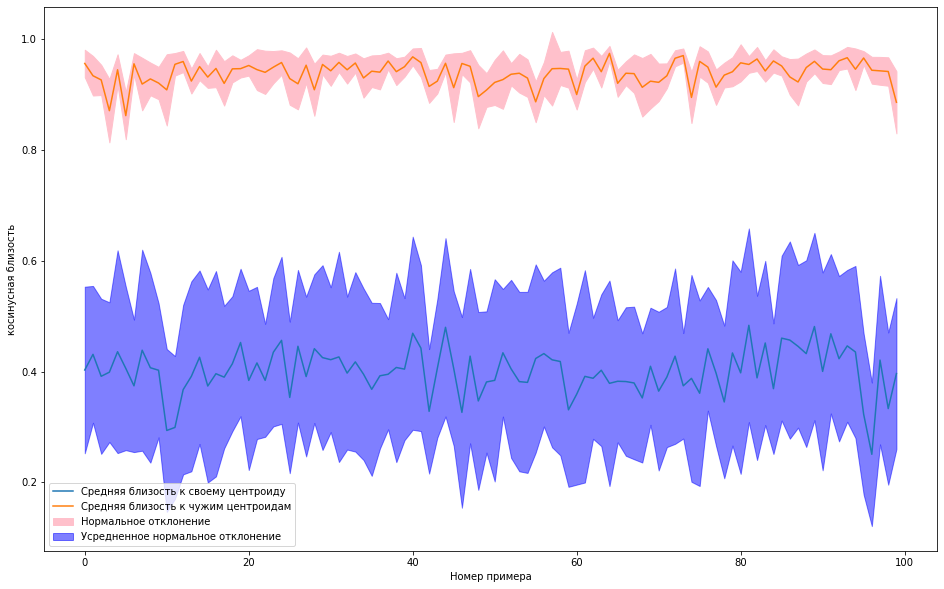

In [28]:
#LibriSpeech
fig, ax = plt.subplots()
plt.plot(mdm,label = "Средняя близость к своему центроиду")
plt.plot(np.array(mdr[0]),label = "Средняя близость к чужим центроидам")
#plt.plot(s[0],Mm,color = 'green',label = 'максимум близости к чужому центроиду (из 20)')
ax.fill_between(N,np.array(mdr[0])-mdr[1],np.array(mdr[0])+mdr[1],color = 'pink', label = 'Нормальное отклонение')
ax.fill_between(N,np.array(mdm)-mdd,np.array(mdm)+mdd,alpha = 0.5,color = 'blue', label = 'Усредненное нормальное отклонение')
ax.set_xlabel("Номер примера")
ax.set_ylabel('косинусная близость')
ax.legend()
fig.set_figwidth(16)    
fig.set_figheight(10)  

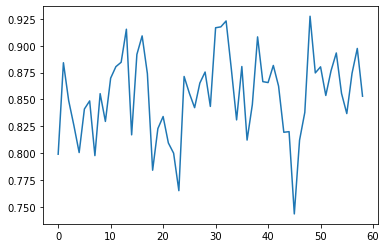

In [224]:
plt.plot(Err[2])
#plt.plot(Ero[2])

In [204]:
w = pad_sequence([vox1[1][0][1]]*3)

In [197]:
len(w[0])

6

In [205]:
cos(w,pad_sequence(Vc[:3]))

tensor([0.5033, 0.9048, 0.3835])